In [1]:
import rerun as rr
import genjax
import os
import numpy as np
import jax.numpy as jnp
import jax
from b3d import Pose
import b3d
from tqdm import tqdm
import trimesh
import pytest
from PIL import Image
import matplotlib.pyplot as plt


In [2]:
PORT = 8812
rr.init("233")
rr.connect(addr=f"127.0.0.1:{PORT}")

[2024-06-30T23:49:37Z WARN  re_sdk_comms::buffered_client] Failed to send message after 3 attempts: Failed to connect to Rerun server at 127.0.0.1:8812: Connection refused (os error 111)
[2024-06-30T23:49:39Z WARN  re_sdk_comms::buffered_client] Dropping messages because tcp client has timed out.
[2024-06-30T23:49:39Z WARN  re_sdk_comms::buffered_client] Dropping messages because tcp client has timed out.
[2024-06-30T23:49:39Z WARN  re_sdk_comms::tcp_client] Tried to flush while TCP stream was still Pending. Data was possibly dropped.


### Define likelihood

### Render images and set up experiment

/opt/conda/envs/b3d2/lib/python3.12/site-packages/trimesh/grouping.py:99: RuntimeWarning: invalid value encountered in cast
  stacked = np.column_stack(stacked).round().astype(np.int64)


Vertices dimensions : [0.116984   0.09313101 0.081303  ]


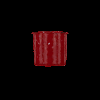

In [3]:
image_width, image_height, fx, fy, cx, cy, near, far = (
    100,
    100,
    200.0,
    200.0,
    50.0,
    50.0,
    0.01,
    10.0,
)
renderer = b3d.Renderer(image_width, image_height, fx, fy, cx, cy, near, far)

mesh_path = os.path.join(
    b3d.get_root_path(), "assets/shared_data_bucket/025_mug/textured.obj"
)
mesh = trimesh.load(mesh_path)
vertices = jnp.array(mesh.vertices)
vertices = vertices - jnp.mean(vertices, axis=0)
faces = jnp.array(mesh.faces)
vertex_colors = vertices * 0.0 + jnp.array([1.0, 0.0, 0.0])
vertex_colors = jnp.array(mesh.visual.to_color().vertex_colors)[..., :3] / 255.0
print("Vertices dimensions :", vertices.max(0) - vertices.min(0))

key = jax.random.PRNGKey(0)

camera_pose = Pose.from_position_and_target(
    jnp.array([0.5, 0.0, 0.0]), jnp.array([0.0, 0.0, 0.0])
)

cp_to_pose = lambda cp: Pose(
    jnp.array([cp[0], cp[1], 0.0]),
    b3d.Rot.from_rotvec(jnp.array([0.0, 0.0, cp[2]])).as_quat(),
)
object_library = b3d.MeshLibrary.make_empty_library()
object_library.add_object(vertices, faces, vertex_colors)

cps_to_test = [
    jnp.array([0.0, 0.0, jnp.pi]),  # Hidden
    jnp.array([0.0, 0.0, -jnp.pi / 2]),  # Side
    jnp.array([0.0, 0.0, 0.0]),  # Front
    jnp.array([0.0, 0.0, +jnp.pi / 2]),  # Side
]

text_index = 0 # 1

gt_cp = cps_to_test[text_index]

object_pose = cp_to_pose(gt_cp)

gt_img, gt_depth = renderer.render_attribute(
    (camera_pose.inv() @ object_pose)[None, ...],
    object_library.vertices,
    object_library.faces,
    object_library.ranges[jnp.array([0])],
    object_library.attributes,
)
b3d.get_rgb_pil_image(gt_img)

### Generate and split poses into batches

In [4]:

delta_cps = jnp.stack(
    jnp.meshgrid(
        jnp.linspace(-0.02, 0.02, 31),
        jnp.linspace(-0.02, 0.02, 31),
        jnp.linspace(-jnp.pi, jnp.pi, 71),
    ),
    axis=-1,
).reshape(-1, 3)
cp_delta_poses = jax.vmap(cp_to_pose)(delta_cps)

test_poses = object_pose @ cp_delta_poses

test_poses_batches = test_poses.split(10)


In [5]:
class PixelOutlier:
    @staticmethod
    def get_rgb_depth_inliers_from_observed_rendered_args(observed_rgb, rendered_rgb, observed_depth, rendered_depth, model_args):
        observed_lab = b3d.colors.rgb_to_lab(observed_rgb)
        rendered_lab = b3d.colors.rgb_to_lab(rendered_rgb)
        error = (
            jnp.linalg.norm(observed_lab[...,1:3] - rendered_lab[...,1:3], axis=-1) + 
            jnp.abs(observed_lab[...,0] - rendered_lab[...,0])
        )

        valid_data_mask = (rendered_rgb.sum(-1) != 0.0)

        color_inliers = (error < model_args.color_tolerance) * valid_data_mask
        depth_inliers = (jnp.abs(observed_depth - rendered_depth) < model_args.depth_tolerance) * valid_data_mask
        inliers = color_inliers * depth_inliers
        outliers = jnp.logical_not(inliers) * valid_data_mask
        undecided = jnp.logical_not(inliers) * jnp.logical_not(outliers)
        return (inliers, color_inliers, depth_inliers, outliers, undecided, valid_data_mask)

    @staticmethod
    def logpdf(observed_rgb, observed_depth, rendered_rgb, rendered_depth, fx, fy, height, width, near, far, model_args):

        inliers, color_inliers, depth_inliers, outliers, undecided, valid_data_mask = PixelOutlier.get_rgb_depth_inliers_from_observed_rendered_args(
            observed_rgb, rendered_rgb, observed_depth, rendered_depth, model_args
        )

        inlier_weight = model_args.inlier_score
        outlier_prob = model_args.outlier_prob
        multiplier = model_args.color_multiplier

        corrected_depth = rendered_depth + (rendered_depth == 0.0) * far
        areas = (corrected_depth / fx) * (corrected_depth / fy)

        inlier_score = inlier_weight * jnp.sum(inliers * areas)
        undecided_score = 1.0 * jnp.sum(undecided * areas)
        outlier_score = outlier_prob * jnp.sum(outliers * areas)

        final_log_score =  jnp.log(
            # This is leaving out a 1/A (which does depend upon the scene)
            inlier_score + 
            undecided_score  +
            outlier_score
        ) * multiplier

        return {'log_score':final_log_score,
                'inlier_score':inlier_score,
                'undecided_score': undecided_score,
                'outlier_score': outlier_score }

    

pixel_outlier_logpdfs = jax.vmap(PixelOutlier.logpdf, (None, None, 0, 0, None, None, None, None, None, None, None))

In [6]:
class RayOutlier:
    @staticmethod
    def get_rgb_depth_inliers_from_observed_rendered_args(observed_rgb, rendered_rgb, observed_depth, rendered_depth, model_args):
        observed_lab = b3d.colors.rgb_to_lab(observed_rgb)
        rendered_lab = b3d.colors.rgb_to_lab(rendered_rgb)
        error = (
            jnp.linalg.norm(observed_lab[...,1:3] - rendered_lab[...,1:3], axis=-1) + 
            jnp.abs(observed_lab[...,0] - rendered_lab[...,0])
        )

        valid_data_mask = (rendered_rgb.sum(-1) != 0.0)

        color_inliers = (error < model_args.color_tolerance) * valid_data_mask
        depth_inliers = (jnp.abs(observed_depth - rendered_depth) < model_args.depth_tolerance) * valid_data_mask
        inliers = color_inliers * depth_inliers
        outliers = jnp.logical_not(inliers)
        teleport_outliers = outliers * (observed_depth > rendered_depth) * (rendered_depth > 0.0)
        nonteleport_outliers = outliers * jnp.logical_not((observed_depth > rendered_depth) * (rendered_depth > 0.0))
        return (inliers, color_inliers, depth_inliers, teleport_outliers, nonteleport_outliers, valid_data_mask)

    @staticmethod
    def logpdf(observed_rgb, observed_depth, rendered_rgb, rendered_depth, fx, fy, height, width, near, far, model_args):

        (inliers, color_inliers, depth_inliers, teleport_outliers, nonteleport_outliers, valid_data_mask) = RayOutlier.get_rgb_depth_inliers_from_observed_rendered_args(
            observed_rgb,
            rendered_rgb,
            observed_depth,
            rendered_depth,
            model_args
        )

        
        observed_depth_corrected = observed_depth + (observed_depth == 0.0) * far

        rendered_areas = (rendered_depth / fx) * (rendered_depth / fy)
        observed_areas = (observed_depth_corrected / fx) * (observed_depth_corrected / fy)

        A = 5
        V = 0.025
        inlier_contribution = jnp.sum(model_args.inlier_score * inliers * rendered_areas * (1-model_args.outlier_prob)/A)

        teleport_factor = 0.00001
        #V = 1/3 * jnp.power(far, 3) * width * height * 1/(fx * fy)
        outlier_contribution_teleporation = jnp.sum(teleport_outliers * observed_areas / V * teleport_factor * model_args.outlier_prob)
        outlier_contribution_not_teleportation = jnp.sum(nonteleport_outliers * observed_areas / V * model_args.outlier_prob * (observed_depth <= rendered_depth))

        final_log_score =  jnp.log(inlier_contribution + outlier_contribution_teleporation + outlier_contribution_not_teleportation) * model_args.color_multiplier
        return {'log_score':final_log_score ,
                'inlier_score': inlier_contribution,
                'outlier_teleport_score': outlier_contribution_teleporation, 
                'outlier_no_teleport_score': outlier_contribution_not_teleportation}
    

ray_outlier_logpdfs = jax.vmap(RayOutlier.logpdf, (None, None, 0, 0, None, None, None, None, None, None, None))

### Pixel outlier experiment

In [7]:

scores = []
inlier_scores = []
undecided_scores = []
outlier_scores = []

for batch in test_poses_batches:
    rgb_ims, depth_ims = renderer.render_attribute_many(
        (camera_pose.inv() @ batch)[:,None, ...],
        object_library.vertices,
        object_library.faces,
        object_library.ranges[jnp.array([0])],
        object_library.attributes,
    )


    color_error, depth_error = (60.0, 0.02)
    inlier_score, outlier_prob = (5.0, 0.00001)
    color_multiplier, depth_multiplier = (10000.0, 500.0)
    model_args = b3d.bayes3d.ModelArgs(
        color_error,
        depth_error,
        inlier_score,
        outlier_prob,
        color_multiplier,
        depth_multiplier,
    )

    scores_dict = pixel_outlier_logpdfs(gt_img, gt_depth, rgb_ims, depth_ims, renderer.fx,renderer.fy, renderer.height, renderer.width, renderer.near, renderer.far, model_args)
    scores_batch = scores_dict['log_score']
    scores.append(scores_batch)
    inlier_scores.append(scores_dict['inlier_score'])
    undecided_scores.append(scores_dict['undecided_score'])
    outlier_scores.append(scores_dict['outlier_score'])

scores = jnp.concatenate(scores)
inlier_scores = jnp.concatenate(inlier_scores)
undecided_scores = jnp.concatenate(undecided_scores)
outlier_scores = jnp.concatenate(outlier_scores)
samples = jax.random.categorical(key, scores, shape=(50,))
    


In [8]:
rr.log("observed_depth_no_background", rr.DepthImage(gt_depth))
gt_depth = jnp.where(gt_depth == 0.0, jnp.ones(gt_depth.shape)*renderer.far, gt_depth)


scores = scores_dict['log_score']


samples = jax.random.categorical(key, scores, shape=(50,))
print("GT Contact Parameter :", gt_cp)

samples_deg_range = jnp.rad2deg(
    (
        jnp.max(delta_cps[samples], axis=0)
        - jnp.min(delta_cps[samples], axis=0)
    )[2]
)

print("Sampled Angle Range:", samples_deg_range)

alternate_camera_pose = Pose.from_position_and_target(
    jnp.array([0.01, 0.000, 0.9]), object_pose.pos
)
alternate_view_images, _ = renderer.render_attribute_many(
    (alternate_camera_pose.inv() @ test_poses[samples])[:, None, ...],
    object_library.vertices,
    object_library.faces,
    object_library.ranges[jnp.array([0])],
    object_library.attributes,
)


#print(samples_deg_range, sampled_degree_range_bounds[text_index][0], sampled_degree_range_bounds[text_index][1])
print(cp_delta_poses[jnp.argmax(scores)])


GT Contact Parameter : [0.        0.        3.1415927]
Sampled Angle Range: 36.0
Pose(position=Array([-0.01733333, -0.01733333,  0.        ], dtype=float32), quaternion=Array([ 0.        ,  0.        , -0.91952777,  0.39302504], dtype=float32))


Text(0, 0.5, 'pdf value')

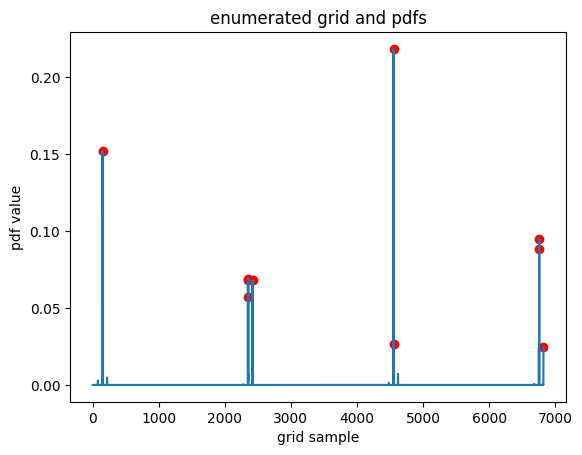

In [9]:
plt.plot(b3d.normalize_log_scores(scores))
plt.scatter(jnp.argsort(scores)[::-1][:10], b3d.normalize_log_scores(scores)[jnp.argsort(scores)[::-1][:10]], color='r')
plt.title('enumerated grid and pdfs')
plt.xlabel('grid sample')
plt.ylabel('pdf value')

Text(0, 0.5, 'log pdf value')

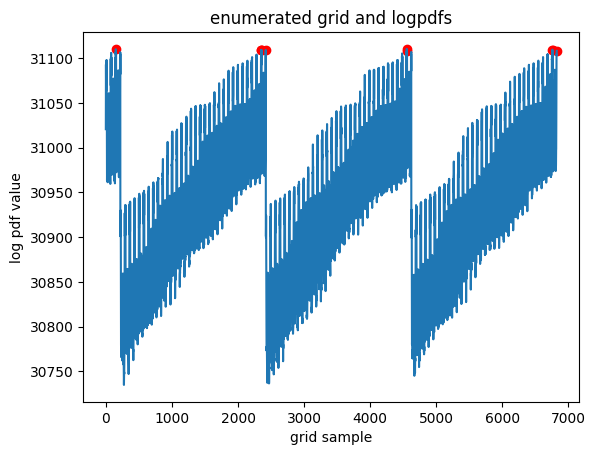

In [10]:
plt.plot(scores)
plt.scatter(jnp.argsort(scores)[::-1][:10], scores[jnp.argsort(scores)[::-1][:10]], color='r')
plt.title('enumerated grid and logpdfs')
plt.xlabel('grid sample')
plt.ylabel('log pdf value')

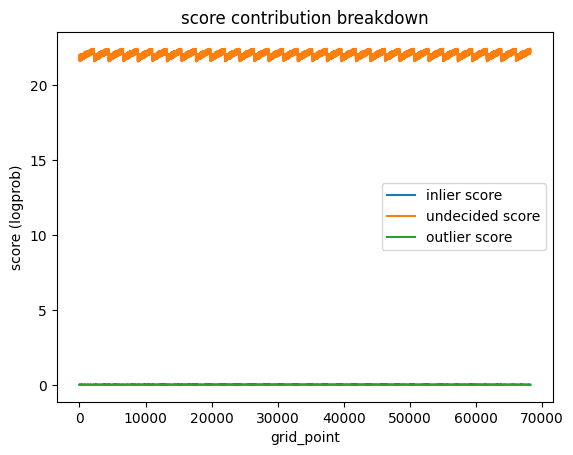

In [11]:
plt.plot(inlier_scores, label='inlier score')
plt.plot(undecided_scores, label='undecided score')
plt.plot(outlier_scores, label='outlier score')
plt.title('score contribution breakdown')
plt.xlabel('grid_point')
plt.ylabel('score (logprob)')
plt.legend()

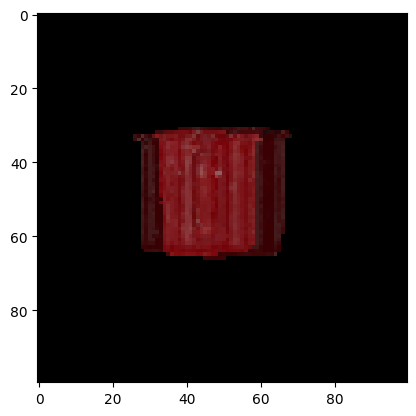

In [12]:
plt.imshow((rgb_ims[jnp.argmax(scores)] + gt_img)/2)

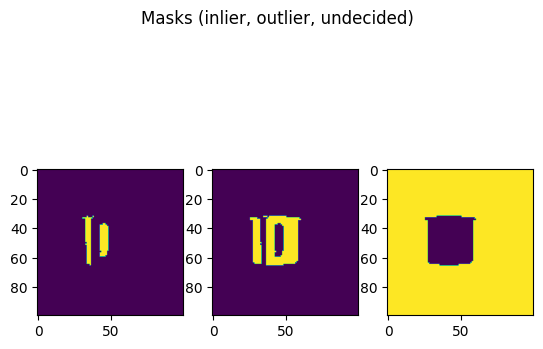

In [13]:
inliers, _, _, outliers, undecided, _ = PixelOutlier.get_rgb_depth_inliers_from_observed_rendered_args(gt_img, rgb_ims[jnp.argmax(scores)], gt_depth, depth_ims[jnp.argmax(scores)],  model_args)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Masks (inlier, outlier, undecided)')
ax1.imshow(inliers)
ax2.imshow(outliers)
ax3.imshow(undecided)

In [14]:
# make gif if best-scoring samples
b3d.make_gif_from_pil_images([b3d.overlay_image(Image.fromarray(np.array(rgb_ims[ind]*255).astype(np.uint8)), Image.fromarray(np.array(gt_img*255).astype(np.uint8)))
                              for ind in jnp.argsort(scores)[::-1][:25]], 'pixel_outlier_samples.gif'
)

### Ray outlier experiment

In [15]:
scores = []
inlier_scores = []
outlier_tele_scores = []
outlier_no_tele_scores = []

for batch in test_poses_batches:
    rgb_ims, depth_ims = renderer.render_attribute_many(
        (camera_pose.inv() @ batch)[:,None, ...],
        object_library.vertices,
        object_library.faces,
        object_library.ranges[jnp.array([0])],
        object_library.attributes,
    )


    color_error, depth_error = (100.0, 0.005)
    #inlier_score, outlier_prob = (5.0, 0.00001)
    inlier_score, outlier_prob = (25.0, 0.01)
    #color_multiplier, depth_multiplier = (10000.0, 500.0)
    color_multiplier, depth_multiplier = (5.0, 500.0)
    model_args = b3d.bayes3d.ModelArgs(
        color_error,
        depth_error,
        inlier_score,
        outlier_prob,
        color_multiplier,
        depth_multiplier,
    )

    scores_dict = ray_outlier_logpdfs(gt_img, gt_depth, rgb_ims, depth_ims, renderer.fx,renderer.fy, renderer.height, renderer.width, renderer.near, renderer.far, model_args)
    scores_batch = scores_dict['log_score']
    scores.append(scores_batch)
    inlier_scores.append(scores_dict['inlier_score'])
    outlier_tele_scores.append(scores_dict['outlier_teleport_score'])
    outlier_no_tele_scores.append(scores_dict['outlier_no_teleport_score'])

scores = jnp.concatenate(scores)
inlier_scores = jnp.concatenate(inlier_scores)
outlier_tele_scores = jnp.concatenate(outlier_tele_scores)
outlier_no_tele_scores = jnp.concatenate(outlier_no_tele_scores)
samples = jax.random.categorical(key, scores, shape=(50,))
print(samples)

[51918 38652 42847 47332 36059 33590 44781 42724 27507 29262 16131 29196
 43064 33595 29556 37918 42589 45057 27364 37982 37926 29855 36459 25154
 44578 36111 27143 49746 36236 27426 11590 35781 49123 33721 37990 48913
 34112 51873 40250 37991 29487 31799 24793 25088 33668 36533 48857 18696
 36182 51528]


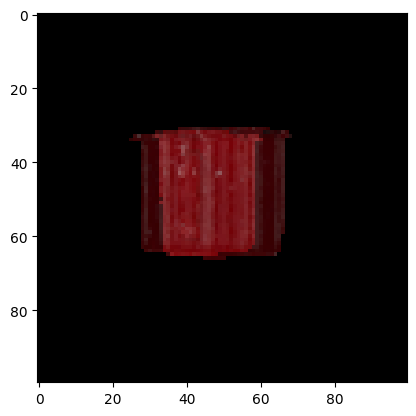

In [16]:
plt.imshow((rgb_ims[jnp.argmax(scores)] + gt_img)/2)

In [17]:
rr.log("observed_depth_no_background", rr.DepthImage(gt_depth))
gt_depth = jnp.where(gt_depth == 0.0, jnp.ones(gt_depth.shape)*renderer.far, gt_depth)


In [18]:
scores = scores_dict['log_score']
inlier_scores = scores_dict['inlier_score']
outlier_tele_scores = scores_dict['outlier_teleport_score']
outlier_no_tele_scores = scores_dict['outlier_no_teleport_score']


samples = jax.random.categorical(key, scores, shape=(50,))
print("GT Contact Parameter :", gt_cp)

samples_deg_range = jnp.rad2deg(
    (
        jnp.max(delta_cps[samples], axis=0)
        - jnp.min(delta_cps[samples], axis=0)
    )[2]
)

print("Sampled Angle Range:", samples_deg_range)

alternate_camera_pose = Pose.from_position_and_target(
    jnp.array([0.01, 0.000, 0.9]), object_pose.pos
)
alternate_view_images, _ = renderer.render_attribute_many(
    (alternate_camera_pose.inv() @ test_poses[samples])[:, None, ...],
    object_library.vertices,
    object_library.faces,
    object_library.ranges[jnp.array([0])],
    object_library.attributes,
)


# print(samples_deg_range, sampled_degree_range_bounds[text_index][0], sampled_degree_range_bounds[text_index][1])
print(cp_delta_poses[jnp.argmax(scores)])


GT Contact Parameter : [0.        0.        3.1415927]
Sampled Angle Range: 354.85715
Pose(position=Array([-0.00133333, -0.02      ,  0.        ], dtype=float32), quaternion=Array([0.        , 0.        , 0.9195277 , 0.39302516], dtype=float32))


Text(0, 0.5, 'pdf value')

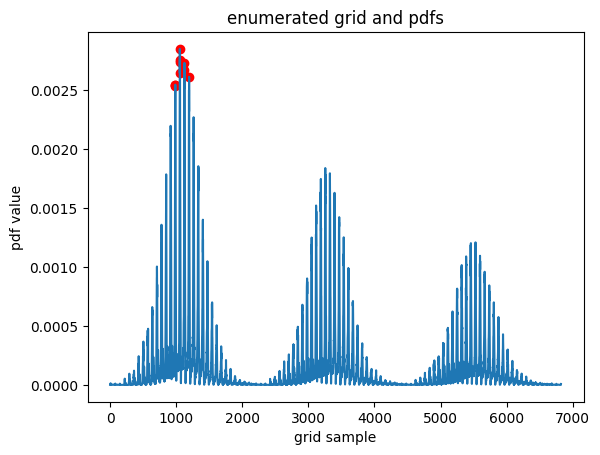

In [19]:
plt.plot(b3d.normalize_log_scores(scores))
plt.scatter(jnp.argsort(scores)[::-1][:10], b3d.normalize_log_scores(scores)[jnp.argsort(scores)[::-1][:10]], color='r')
plt.title('enumerated grid and pdfs')
plt.xlabel('grid sample')
plt.ylabel('pdf value')

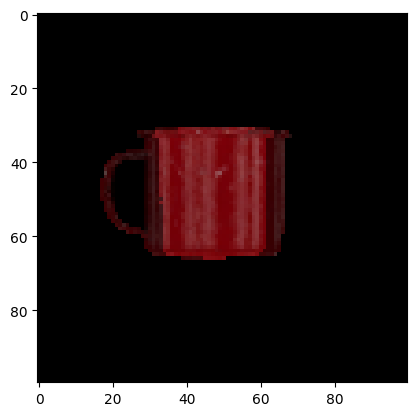

In [20]:
# show sample
plt.imshow((rgb_ims[jnp.argsort(scores)[::-1][7]] + gt_img)/2)

Text(0, 0.5, 'score')

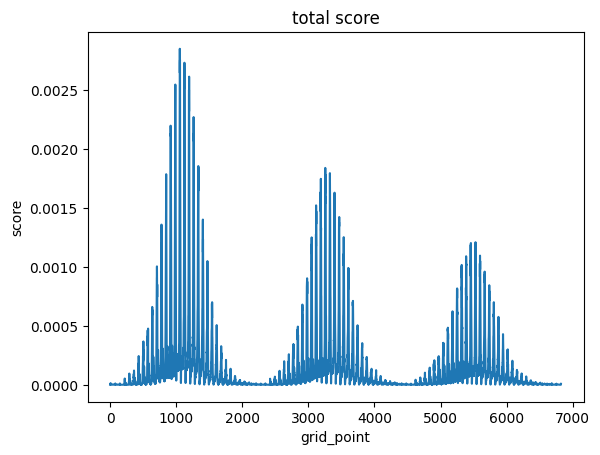

In [21]:
plt.plot(b3d.normalize_log_scores(scores))
plt.title('total score')
plt.xlabel('grid_point')
plt.ylabel('score')

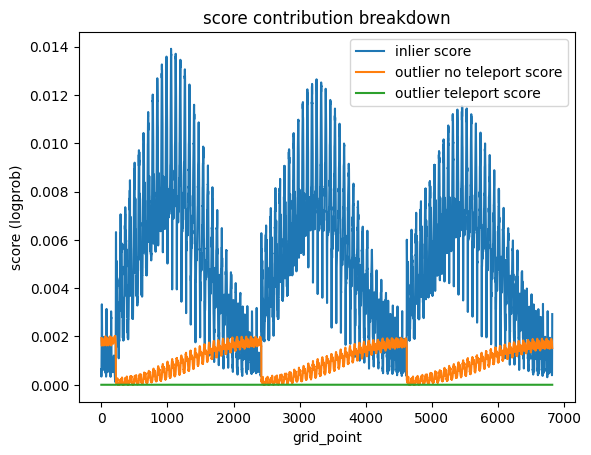

In [22]:
plt.plot(inlier_scores, label='inlier score')
plt.plot(outlier_no_tele_scores, label='outlier no teleport score')
plt.plot(outlier_tele_scores, label='outlier teleport score')
plt.title('score contribution breakdown')
plt.xlabel('grid_point')
plt.ylabel('score (logprob)')
plt.legend()

### Best-scoring example

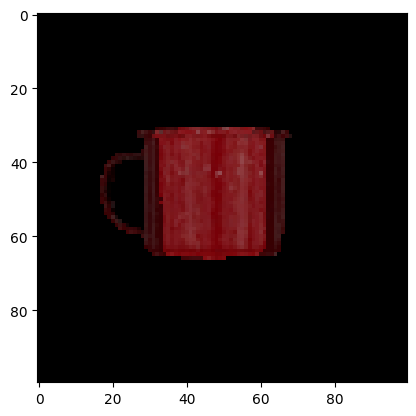

In [23]:
# show sample
plt.imshow((rgb_ims[jnp.argmax(scores)] + gt_img)/2)

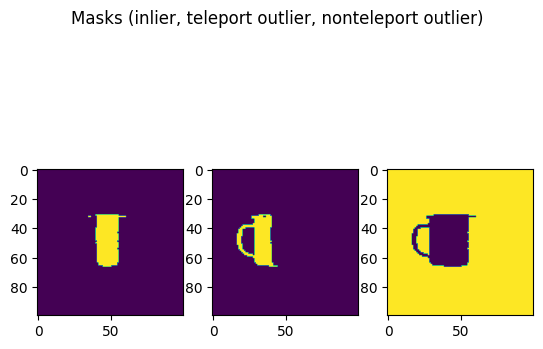

In [24]:
# generate inlier/outlier maps
inliers, _, _, teleport_outliers, nonteleport_outliers, _ = RayOutlier.get_rgb_depth_inliers_from_observed_rendered_args(gt_img, rgb_ims[jnp.argmax(scores)], gt_depth, depth_ims[jnp.argmax(scores)],  model_args)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Masks (inlier, teleport outlier, nonteleport outlier)')
ax1.imshow(inliers)
ax2.imshow(teleport_outliers)
ax3.imshow(nonteleport_outliers)

In [25]:
# make gif if best-scoring samples
b3d.make_gif_from_pil_images([b3d.overlay_image(Image.fromarray(np.array(rgb_ims[ind]*255).astype(np.uint8)), Image.fromarray(np.array(gt_img*255).astype(np.uint8)))
                              for ind in jnp.argsort(scores)[::-1][:25]], 'ray_outlier_samples.gif'
)

In [26]:
jnp.argsort(scores)[::-1][:10]

Array([1055, 1058, 1057, 1125, 1126, 1056, 1196,  987,  988,  986], dtype=int32)